In [1]:
import numpy as np
import tensorflow as tf
import gpflow
from scipy import linalg
from matplotlib import pyplot as plt

import domain as dom
import function as fun
import learn as lrn
import utilities as utils

# Dynamical model of an inverted pendulum

In [2]:
# ---------------------------------------------------------------------------*/
# - model an inverted pendulum

# true model parameters of a pendulum system
mass_true = 0.15
friction_true = 0.1
length_true = 0.5
inertia_true = mass_true * length_true ** 2

# wrong model parameters for the pendulum
mass = 0.1 # less mass!!
friction = 0. # no friction!!
length = length_true
gravity = 9.81
inertia = mass * length ** 2

# state saturation
angle_max = np.deg2rad(30)
eigfreq = np.sqrt(gravity/length) # eigen, or natural, frequency
state_max = [angle_max, eigfreq]

# control action saturation, i.e. max torque [m/s^2 * kg * m = kg * m^2 / s^2 = m * N]
torque_max = gravity * mass_true * length_true * np.sin(angle_max)
action_max = torque_max

# instantiate two types of inverted pendulum dynamics, with wrong anf true parameters
pendulum = fun.pendulum_inv(
    mass, length, friction,
    normalization=(state_max, action_max))

pendulum_true = fun.pendulum_inv(
    mass_true, length_true, friction_true,
    normalization=(state_max, action_max))


### Domain discretization

In [3]:
# ---------------------------------------------------------------------------*/
# - discretize a normalized domain

dims_lim = [(-2.0, 2.0), (-1.5, 1.5)]
domain = dom.gridworld(dims_lim, dims_sz=[2001, 1501])

# show domain statistics
print(f'Grid size is {len(domain)}')

tau = np.min(domain.step)
print(f'Discretization step equals {tau:.3f}')

Grid size is 3003501
Discretization step equals 0.002


### Initial optimal policy for a linearized model

In [4]:
# ---------------------------------------------------------------------------*/
# - linearize model dynamics

a, b = pendulum.linearize()

dyn_linear = fun.linear([a, b])
dyn_angle_linear = fun.linear([a[[0], :], b[[0], :]])
dyn_velocity_linear = fun.linear([a[[1], :], b[[1], :]])


# ---------------------------------------------------------------------------*/
# - initial control policy

# lqr cost matrices for state and control,
# which encode how the performance of the angular velocity is
# penalized more, than the angle. Meanwhile, the control cost r is penalized only slightly.
q = 1 * np.diag([1.0, 2.0])
r = 1.2 * np.array([[1.0]])

# compute an optimal policy for the linearized model dynamics
lqr_ctl, lqr_solution = utils.make_dlqr(a, b, q, r)

# lqr policy is u = -K*x,
# where x is the state and K is the full-state feedback matrix
policy_initial = fun.saturated(fun.linear([-lqr_ctl]), 1.0)

### Definition of stochastic models

In [5]:
# ---------------------------------------------------------------------------*/
# - model uncertainty

ab = tf.concat((a, b), axis=1)
ab_true = tf.concat((pendulum_true.linearize()), axis=1)

# compute error (variance) between the true and wrong dynamics
dyn_error = (ab_true - ab) ** 2

error_angle = (
    gpflow.kernels.Linear(variance=dyn_error[0, :], active_dims=np.arange(len(dyn_error[0, :]))) +
    gpflow.kernels.Matern32(lengthscales=1, active_dims=[0]) *
    gpflow.kernels.Linear(variance=dyn_error[0, 1]))

error_velocity = (
    gpflow.kernels.Linear(variance=dyn_error[1, :]) +
    gpflow.kernels.Matern32(lengthscales=1, active_dims=[0]) *
    gpflow.kernels.Linear(variance=dyn_error[1, 1]))

# define observation noise
sample_ns_var = tf.constant(0.01 ** 2, dtype=gpflow.default_float())

# use error information to instantiate stochastic dynamics,
# but do not set any policies right now
dyn_angle = fun.dynamics(dyn_angle_linear, error=error_angle, noise=sample_ns_var)
dyn_velocity = fun.dynamics(dyn_velocity_linear, error=error_velocity, noise=sample_ns_var)

# stack together stochastic functions, which are scalar, to form a vector-valued function
dyn = fun.stochastic_stacked([dyn_angle, dyn_velocity])

# Dynamic programming

### Configure a dynamic programming problem

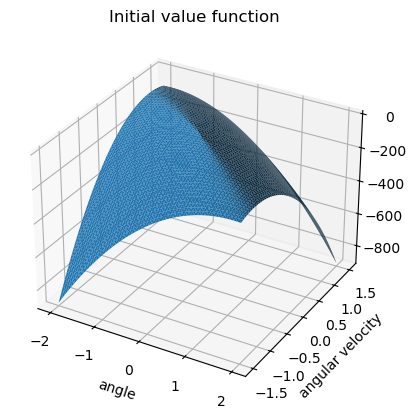

In [6]:
# ---------------------------------------------------------------------------*/
# - initial lyapunov function candidate

# an initial lyapunov function is quadratic and based on the initial optimal policy
lyap_initial = fun.quadratic(lqr_solution)


# ---------------------------------------------------------------------------*/
# - reward function

# rewards are strictly negative away from the origin
reward = fun.quadratic(linalg.block_diag(-q, -r))


# ---------------------------------------------------------------------------*/
# - auxiliary domain for value discretization

# to speed up processing time this value function is discretized coarsely
domain_value = dom.gridworld(dims_lim, dims_sz=55)


# ---------------------------------------------------------------------------*/
# - value function approximated using triangulation

# value is initialized with negative values of the initial lyapunov function
value = fun.triangulation(domain_value, -lyap_initial(domain_value.states))

fig, ax = utils.plot3d_triangulation(value)
ax.set_title('Initial value function')
ax.set_xlabel("angle")
ax.set_ylabel("angular velocity")
plt.show()


# ---------------------------------------------------------------------------*/
# - policy iteration

# use policy iteration to solve this reinforcement learning problem
rl = lrn.policy_iter(policy_initial, dyn, reward, value)


### Run dynamic programming

In [7]:
states = domain.sample_continuous(100)
values = rl.evaluate(states)

loss = -np.mean(values)
print(loss)

182.0021955397446


# Simulation

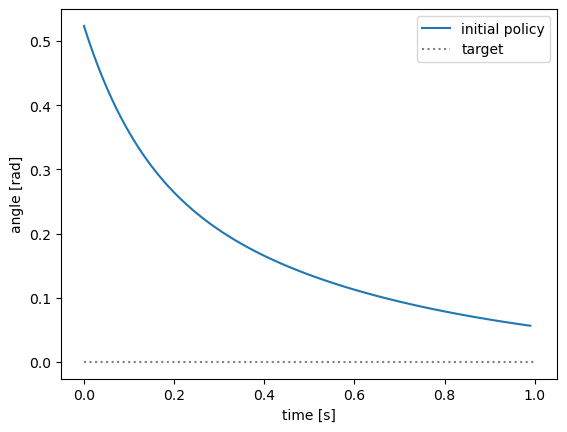

In [8]:
# ---------------------------------------------------------------------------*/
# simulate result and plot

# create a sequence of states for simulation and set the initial state
sim_states = np.zeros((100, 2), dtype=float)
sim_states[0] = [1.0, -0.5] # initial state

# prepare pendulum dynamics for simulation
pendulum_true.policy = policy_initial

# simulate
for this in range(len(sim_states) - 1):
    sim_states[this + 1] = pendulum_true(sim_states[this])

time = np.arange(len(sim_states)) * pendulum_true.timestep
data = pendulum_true.denormalize_state(sim_states)

# plot simulated state trajectory
policy_initial_plt = plt.plot(time, data[:, 0], label=r'initial policy')
plt.xlabel("time [s]")
plt.ylabel("angle [rad]")

# plot policy target, i.e. a pendulum in its upright position, where angle equals 0
policy_target_plt = plt.plot([0, 1], [0, 0], color='grey', linestyle='dotted', label=r'target')

# plot legend
lns = policy_initial_plt + policy_target_plt
labels = [l.get_label() for l in lns]
plt.legend(lns, labels, loc=1, fancybox=True, framealpha=0.75)

# show plotting
plt.show()